In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
from datasets import load_dataset
import pandas as pd
import random
random.seed(123)
import torch

import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re



In [ ]:
#The file path is the path to the dataset you want to extract
#Uncomment the below line and comment the next line to extract the dataset
#dataframe = pd.read_csv("./MISC/extracted_dataset.csv")
dataframe = pd.read_csv("/content/extracted_dataset.csv")

In [4]:
columns_to_remove = ["processing_time", "input_tokens","output_tokens","api_cost","timestamp","model","id"]
dataframe = dataframe.drop(columns=columns_to_remove)


In [5]:
dataframe.head()

,job_ad,json
0,Job title: Financial Account - Call Center Age...,"{\n ""salary"": ""[15000-20000-PHP-monthly]"",\..."
1,Job title: Aspiring Call Center Agents - Work ...,"{\n ""salary"": ""[15000-20000-PHP-monthly]"",\..."
2,Job title: Production Staff Required - Afterno...,"{\n ""salary"": ""[None-None-None-None]"",\n ..."
3,Job title: Payer Analyst\nContents: \n\nThe Pa...,"{\n ""salary"": ""[None-None-None-None]"",\n ..."
4,"Job title: Solicitor, Restructuring (ID: 21000...","{\n ""salary"": ""[0-0-None-None]"",\n ""work..."


In [6]:
import json

# If the JSON is stored as a string, parse it
dataframe['json_dict'] = dataframe['json'].apply(json.loads)

# Extract fields into new columns
dataframe['work_arrangements'] = dataframe['json_dict'].apply(lambda x: x.get('work_arrangements'))
dataframe['seniority'] = dataframe['json_dict'].apply(lambda x: x.get('seniority'))

dataframe = dataframe.drop(columns=['json_dict','json'])


In [7]:
dataframe.head()

,job_ad,work_arrangements,seniority
0,Job title: Financial Account - Call Center Age...,on-site,entry level
1,Job title: Aspiring Call Center Agents - Work ...,remote,entry level
2,Job title: Production Staff Required - Afterno...,on-site,experienced
3,Job title: Payer Analyst\nContents: \n\nThe Pa...,on-site,mid
4,"Job title: Solicitor, Restructuring (ID: 21000...",on-site,senior


In [8]:

def clean_html(text):
    """Remove HTML tags from text"""
    if isinstance(text, str):
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
dataframe['job_ad'] = dataframe['job_ad'].apply(clean_html)

In [10]:
# Keep only rows where 'seniority' is NOT a dictionary and NOT a list
dataframe = dataframe[~dataframe['seniority'].apply(lambda x: isinstance(x, dict))].reset_index(drop=True)
dataframe = dataframe[~dataframe['seniority'].apply(lambda x: isinstance(x, list))].reset_index(drop=True)

In [11]:
seniority_map = {
    'entry level': 'entry level',
    'experienced': 'experienced',
    'mid': 'mid',
    'senior': 'senior',
    'executive': 'executive',
    'junior': 'junior',
    'lead': 'lead',
    'manager': 'manager',
    'assistant': 'junior',
    'postdoctoral': 'intern',
    'internship': 'intern',
    'vice president': 'executive',
    'supervisor': 'manager',
    'operations executive': 'executive',
    'trainee': 'entry level',
    'director': 'director',
    'associate': 'junior',
    'casual': 'entry level',
    'team lead': 'lead',
    'self-employed': 'manager',
    'deputy': 'manager',
    'clerk': 'entry level',
    'head': 'manager',
    'postdoc': 'intern',
    'owner': 'executive',
    'partner': 'executive',
    'APS4': 'entry level',
    'coordinator': 'manager',
    'management': 'manager',
    'training': 'entry level',
    'leading hand': 'manager',

    # Group all unknowns
    'Unknown': 'unknown',
    'unknown': 'unknown',
    '[Unknown]': 'unknown',
    '[Unknown, Unknown, mid, Unknown]': 'unknown',

    '[junior, experienced]': 'junior',
    '[experienced]': 'experienced',
    'junior,senior,experienced': 'experienced',
    'senior for Senior, junior for Junior': 'unknown',
}


In [12]:
def map_seniority(label):
    # Remove extra spaces and lowercase for consistency
    label = str(label).strip().lower()

    # Map, default to 'unknown'
    return seniority_map.get(label, 'unknown')

dataframe['seniority_mapped'] = dataframe['seniority'].apply(map_seniority)

In [13]:
dataframe = dataframe.drop(columns=["seniority"])

In [14]:
seniority_labels = dataframe['seniority_mapped'].unique().tolist()
seniority_labels = [s.strip() for s in seniority_labels ]
seniority_labels

['entry level',
 'experienced',
 'mid',
 'senior',
 'executive',
 'junior',
 'lead',
 'manager',
 'unknown',
 'intern',
 'director']

In [15]:
work_arrangement_map = {
    'on-site': 'on-site',
    'remote': 'remote',
    'hybrid': 'hybrid',
    'unknown': 'unknown',
    'Unknown': 'unknown',
    'casual': 'casual',
    'contract': 'contract',
    'parttime': 'part-time',
    'part-time': 'part-time',
    'casual/vacation': 'casual',
    'fifo': 'shift',
    'fifo or residential': 'shift',
    'dido': 'shift',
    'shift': 'shift',
    'shifts': 'shift',
    'rotating': 'shift',
    'rotating shift': 'shift',
    'rotational': 'shift',
    'night shift': 'shift',
    'temporary/contract': 'contract',
    'temp/contract': 'contract',
    'fixed-term': 'contract',
    'fixed-term contract': 'contract',
    'temp to perm': 'contract',
    'temporary': 'contract',
    'temp 3 days p/w': 'part-time',
    'extendable': 'contract',
    'negotiable': 'flexible',
    'flexible': 'flexible',
    'flexi': 'flexible',
    'flexible full-time': 'flexible',
    'fulltime': 'full-time',
    'full-time': 'full-time',
    'part-time/full-time': 'flexible',
    'relocation': 'on-site',
    'residential': 'on-site',
    'community-based': 'on-site',
    'office and site based': 'on-site',
    'offshore': 'on-site',
    'autonomous': 'flexible',
    'travel': 'flexible',
    'location and/or work from home opportunities to be considered for this role': 'flexible'
}


In [16]:
def map_work_arrangement(label):
    label = str(label).strip().lower()
    return work_arrangement_map.get(label, 'unknown')

dataframe['work_arrangements_mapped'] = dataframe['work_arrangements'].apply(map_work_arrangement)


In [17]:
dataframe = dataframe.drop(columns=["work_arrangements"])

In [18]:
work_labels = dataframe['work_arrangements_mapped'].unique().tolist()
work_labels = [s.strip() for s in work_labels ]
work_labels

['on-site',
 'remote',
 'hybrid',
 'unknown',
 'casual',
 'contract',
 'part-time',
 'flexible',
 'shift',
 'full-time']

In [19]:
dataframe

,job_ad,seniority_mapped,work_arrangements_mapped
0,Job title: Financial Account - Call Center Age...,entry level,on-site
1,Job title: Aspiring Call Center Agents - Work ...,entry level,remote
2,Job title: Production Staff Required - Afterno...,experienced,on-site
3,Job title: Payer Analyst Contents: The Payer A...,mid,on-site
4,"Job title: Solicitor, Restructuring (ID: 21000...",senior,on-site
...,...,...,...
7223,Job title: E-commerce Key Account Manager Cont...,mid,on-site
7224,Job title: Tiktok Content Creator & Video desi...,entry level,on-site
7225,Job title: BA (Business Analyst) Contents: Res...,junior,on-site
7226,Job title: ช่างเทคนิค Contents: Job Descriptio...,entry level,on-site


In [ ]:
#Stratified Split the entire dataset since work_arrangements is imbalanced
train, test = train_test_split(dataframe, test_size=0.2, stratify=dataframe.work_arrangements_mapped)
train, val = train_test_split(train, test_size=0.15,stratify=train.work_arrangements_mapped)

train.shape, test.shape, val.shape

((4914, 3), (1446, 3), (868, 3))

In [21]:
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

In [22]:
#Convert dataframes to HuggingFace DatasetDict format
data = datasets.DatasetDict(
    {
        'train': datasets.Dataset.from_pandas(train),
        'val': datasets.Dataset.from_pandas(val),
        'test': datasets.Dataset.from_pandas(test)
    }
)
data

DatasetDict({
    train: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__'],
        num_rows: 4914
    })
    val: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__'],
        num_rows: 868
    })
    test: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__'],
        num_rows: 1446
    })
})

In [23]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [24]:
from datetime import datetime
import evaluate

import torch
import torch.nn as nn

from transformers import Trainer, TrainerCallback, TrainingArguments, EarlyStoppingCallback
from transformers import AutoTokenizer, BertConfig, BertModel, BertPreTrainedModel

In [25]:


timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

RESULTS_DIRECTORY = './results/experiment_{}'.format(timestamp)

LOGGING_DIRECTORY = './logs/experiement_{}'.format(timestamp)

RESULTS_DIRECTORY, LOGGING_DIRECTORY


('./results/experiment_2025-04-28_02-57-56',
 './logs/experiement_2025-04-28_02-57-56')

In [26]:
#Define the target seniority labels
SENIORITY_LABELS = [
 'entry level',
 'experienced',
 'mid',
 'senior',
 'executive',
 'junior',
 'lead',
 'manager',
 'unknown',
 'intern',
 'director'
]

#Define the target work_arrangements labels
WORK_LABELS = [
 'on-site',
 'remote',
 'hybrid',
 'unknown',
 'casual',
 'contract',
 'part-time',
 'flexible',
 'shift',
 'full-time'
]

#Label2IDX and IDX2Labels

SENIORITY_LABELS_TO_IDX = {
    i : idx
    for idx, i in enumerate(SENIORITY_LABELS)
}

IDX_TO_SENIORITY_LABELS = {
    i: j
    for j, i in SENIORITY_LABELS_TO_IDX.items()
}

WORK_LABELS_TO_IDX = {
    i : idx
    for idx, i in enumerate(WORK_LABELS)
}

IDX_TO_WORK_LABELS = {
    i: j
    for j, i in WORK_LABELS_TO_IDX.items()
}



In [27]:
#Import pre-trained model
MAX_SEQUENCE_LENGTH = 512
PRETRAINED_MODEL_NAME = "distilbert-base-uncased"
NUM_TRAIN_EPOCHS = 10

In [28]:
# tokenize function
def tokenize(example, tokenizer):
    return tokenizer(
        example['job_ad'], padding=True, truncation=True
    )


# label encoding
def label_encoder(example):
    example['work_label'] = WORK_LABELS_TO_IDX[example['work_arrangements_mapped']]
    example['seniority_label'] = SENIORITY_LABELS_TO_IDX[example['seniority_mapped']]
    return example

In [29]:
# initializing Config and Tokenizer
BERT_CONFIG = BertConfig.from_pretrained(PRETRAINED_MODEL_NAME)
TOKENIZER = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [30]:
#Tokenize all the three datasets(train, test and val)
data = data.map(lambda x: tokenize(x, tokenizer=TOKENIZER))
data = data.map(lambda x: label_encoder(x))

data

Map:   0%|          | 0/4914 [00:00<?, ? examples/s]

Map:   0%|          | 0/868 [00:00<?, ? examples/s]

Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

Map:   0%|          | 0/4914 [00:00<?, ? examples/s]

Map:   0%|          | 0/868 [00:00<?, ? examples/s]

Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__', 'input_ids', 'attention_mask', 'work_label', 'seniority_label'],
        num_rows: 4914
    })
    val: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__', 'input_ids', 'attention_mask', 'work_label', 'seniority_label'],
        num_rows: 868
    })
    test: Dataset({
        features: ['job_ad', 'seniority_mapped', 'work_arrangements_mapped', '__index_level_0__', 'input_ids', 'attention_mask', 'work_label', 'seniority_label'],
        num_rows: 1446
    })
})

In [ ]:
# Defining the metrics
# we will be using F1 scores for both work_arrangements and seniority

WORK_METRIC = evaluate.load("f1")
SENIORITY_METRIC = evaluate.load("f1")

def compute_metrics(eval_pred):
    # eval_pred is a tuple of (predictions, labels)
    # predictions is a tuple of (work_logits, seniority_logits)
    # labels is a tuple of (work_labels, seniority_labels)
    all_logits, all_labels = eval_pred
    work_logits, seniority_logits = all_logits
    work_labels, seniority_labels = all_labels

    work_predictions = np.argmax(work_logits, axis=-1)
    seniority_predictions = np.argmax(seniority_logits, axis=-1)

    work_computed_metrics = WORK_METRIC.compute(predictions=work_predictions, references=work_labels, average='weighted')
    seniority_computed_metrics = SENIORITY_METRIC.compute(predictions=seniority_predictions, references=seniority_labels, average='weighted')

    return {
        'f1_work_arrangements': work_computed_metrics['f1'],
        'f1_seniority': seniority_computed_metrics['f1'],
    }

In [ ]:
# model definition
class MultiTaskClassification(BertPreTrainedModel):
    def __init__(self, config, num_work_labels, num_seniority_labels):
        super().__init__(config)

        # Store the number of labels for each classification task
        self.num_work_labels = num_work_labels
        self.num_seniority_labels = num_seniority_labels


        # Load pre-trained BERT model
        self.bert = BertModel(config)

        # Define separate classifiers for work arrangement and seniority classification
        self.work_classifier = nn.Linear(config.hidden_size, num_work_labels)
        self.seniority_classifier = nn.Linear(config.hidden_size, num_seniority_labels)

        # Set dropout probability for regularization
        classifier_dropout = config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        self.dropout = nn.Dropout(classifier_dropout)

        # Initialize the model weights
        self.init_weights()

    def forward(
            self, input_ids, attention_mask=None, token_type_ids=None,
            work_label=None, seniority_label=None
    ):
        
        # Pass inputs through BERT to obtain hidden states
        outputs = self.bert(
            input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # outputs[0] contains the hidden states of the last layer - token embeddings
        # outputs[1] contains the pooled output (CLS token representation)
        pooled_outputs = self.dropout(outputs[1])

        # Get logits for each task from the pooled output
        logits_work = self.work_classifier(pooled_outputs)
        logits_seniority = self.seniority_classifier(pooled_outputs)

        loss = None
        if work_label != None and seniority_label != None:

            # Define loss functions for both tasks
            loss_fct1 = nn.CrossEntropyLoss()
            loss_fct2 = nn.CrossEntropyLoss()

            # Compute the sum of both losses
            loss = loss_fct1(
                logits_work.view(-1, self.num_work_labels),
                work_label.view(-1)
            ) + loss_fct2(
                logits_seniority.view(-1, self.num_seniority_labels),
                seniority_label.view(-1)
            )

        # Return loss (if computed) along with logits for both tasks
        return (loss, logits_work, logits_seniority) if loss is not None else (logits_work, logits_seniority)

In [ ]:
# Split samples into different batches
def data_collator(batch, padding_token_id=TOKENIZER.pad_token_id):

    # Extract and truncate 'input_ids' and 'attention_mask' for each item in the batch
    input_ids = [item["input_ids"][:MAX_SEQUENCE_LENGTH] for item in batch]
    attention_masks = [item["attention_mask"][:MAX_SEQUENCE_LENGTH] for item in batch]

    # Extract labels for both tasks from each item in the batch
    work_label = [item["work_label"] for item in batch]
    seniority_label = [item["seniority_label"] for item in batch]

    # Find the maximum sequence length in the batch (after truncation)
    max_len = max(len(ids) for ids in input_ids)

    # Pad 'input_ids' and 'attention_masks' to the maximum length using the padding token
    input_ids = torch.tensor([ids + [padding_token_id] * (max_len - len(ids)) for ids in input_ids])
    attention_masks = torch.tensor([masks + [padding_token_id] * (max_len - len(masks)) for masks in attention_masks])

    # Convert labels to tensors
    work_label = torch.tensor([i for i in work_label])
    seniority_label = torch.tensor([i for i in seniority_label])

    # Return a dictionary containing all necessary inputs for the model
    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "work_label": work_label,
        "seniority_label" : seniority_label
    }

In [34]:
## Load a pre-trained BERT model with a custom head for multitask classification (work arrangement and seniority level)
model = MultiTaskClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    config=BERT_CONFIG,
    num_work_labels=len(WORK_LABELS), num_seniority_labels=len(SENIORITY_LABELS)
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of MultiTaskClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.Lay

In [35]:
output_directory = RESULTS_DIRECTORY
evaluation_strategy = 'epoch'
per_device_train_batch_size = 4
per_device_eval_batch_size = 4
gradint_accumulation_steps = 2
learning_rate = 2e-5
weight_decay = 0.01
max_grad_norm = 1
num_train_epochs = NUM_TRAIN_EPOCHS
lr_scheduler_type = 'linear'
warmup_ratio = 0.05
logging_dir = LOGGING_DIRECTORY
logging_strategy = 'epoch'
save_strategy = 'epoch'
save_total_limit = 1
label_names = ['work_label', 'seniority_label']
load_best_model_at_end = True
metric_for_best_model = 'eval_f1_work_arrangements'
greater_is_better = True
label_smoothing_factor = 0
report_to = 'tensorboard'
gradient_checkpointing = False

In [36]:
# Setup training arguments
training_args = TrainingArguments(
    output_dir=output_directory,
    eval_strategy=evaluation_strategy,
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    logging_dir=logging_dir,
    label_names=label_names,
    max_grad_norm=max_grad_norm,
    lr_scheduler_type=lr_scheduler_type,
    warmup_ratio=warmup_ratio,
    logging_strategy=logging_strategy,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    load_best_model_at_end=load_best_model_at_end,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    label_smoothing_factor=label_smoothing_factor,
    report_to=report_to,
    gradient_checkpointing=gradient_checkpointing
)

early_stop_callback = EarlyStoppingCallback(3)

In [37]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[early_stop_callback]
)

In [38]:
import numpy as np

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Work Arrangements,F1 Seniority
1,2.567000,2.331145,0.718448,0.408910
2,2.130800,2.060073,0.718448,0.478109
3,1.947200,1.996852,0.718448,0.533054
4,1.830800,2.000714,0.718448,0.573241


TrainOutput(global_step=4916, training_loss=2.118968693583452, metrics={'train_runtime': 1093.3612, 'train_samples_per_second': 44.944, 'train_steps_per_second': 11.241, 'total_flos': 2404571985673020.0, 'train_loss': 2.118968693583452, 'epoch': 4.0})

In [40]:
trainer.evaluate()

{'eval_loss': 2.3311450481414795,
 'eval_f1_work_arrangements': 0.7184484720870254,
 'eval_f1_seniority': 0.4089102667685456,
 'eval_runtime': 12.2909,
 'eval_samples_per_second': 70.621,
 'eval_steps_per_second': 17.655,
 'epoch': 4.0}

In [41]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

In [ ]:
# Provide the path of the checkpoint that was created during training
FINETUNED_MODEL_PATH = '/content/results/experiment_2025-04-28_02-57-56/checkpoint-1229'

In [43]:
# Loading the fine-tuned multitask classification model from the saved checkpoint
model = MultiTaskClassification.from_pretrained(
    FINETUNED_MODEL_PATH, config=BERT_CONFIG,
    num_work_labels=len(WORK_LABELS), num_seniority_labels=len(SENIORITY_LABELS)
)
print('Model loaded successfully...')

Model loaded successfully...


In [44]:
from tqdm import tqdm

In [45]:
def get_predictions_on_dataframe(df, model):
    # Lists to store predictions and probabilities for both tasks
    predictions_work = []
    predictions_seniority = []

    probability_work = []
    probability_seniority = []

    # Iterate through each job advertisement text
    for text in tqdm(df.job_ad, total=df.shape[0]):
        if len(text) > 0:

           # Tokenize the input text with padding and truncation
            inputs_to_model = TOKENIZER(text, padding=True, truncation=True)

            # Truncate input_ids and attention_mask to MAX_SEQUENCE_LENGTH and convert to tensors
            inputs_to_model['input_ids'] = torch.tensor([inputs_to_model['input_ids'][:MAX_SEQUENCE_LENGTH]])

            inputs_to_model['attention_mask'] = torch.tensor([inputs_to_model['attention_mask'][:MAX_SEQUENCE_LENGTH]])

            # Disable gradient calculation since we are in inference mode
            with torch.no_grad():
                model_outputs = model(**inputs_to_model)

            # Apply softmax to get probabilities and take the class with highest probability for each task
            overall_prob, overall_pred = torch.max(torch.softmax(model_outputs[0], dim=1), dim=1)
            second_prob, second_pred = torch.max(torch.softmax(model_outputs[1], dim=1), dim=1)

            # Map predicted indices back to their corresponding labels
            predictions_work.append(
                IDX_TO_WORK_LABELS[overall_pred.item()]
            )
            predictions_seniority.append(
                IDX_TO_SENIORITY_LABELS[second_pred.item()]
            )

            # Store the prediction probabilities (rounded for readability)
            probability_work.append(
                round(overall_prob[0].item(), 3)
            )
            probability_seniority.append(
                round(second_prob[0].item(), 3)
            )
        else:

          # Handle empty text cases by appending None
            predictions_work.append(None)
            predictions_seniority.append(None)

            probability_work.append(None)
            probability_seniority.append(None)

    ## Add predictions and their corresponding probabilities back to the dataframe
    df['work_predictions'] = predictions_work
    df['work_pred_probability'] = probability_work
    df['seniority_predictions'] = predictions_seniority
    df['seniority_pred_probability'] = probability_seniority
    return df

In [46]:
test_df = pd.read_csv('/content/test.csv')
print(test_df.shape)
test_df.head()

(1446, 3)


,job_ad,seniority_mapped,work_arrangements_mapped
0,Job title: Casual MC changeover Drivers Conten...,experienced,on-site
1,Job title: 兼職到校課程導師 Contents: 彈性上班時間，工作地點可按個別導...,experienced,on-site
2,Job title: 兼職保安員 Contents: 23-23-0044233 WA 臨時...,experienced,hybrid
3,Job title: PHARMACY PROFESSIONAL SERVICES COOR...,mid,on-site
4,Job title: Board Assembly - Production Soldere...,entry level,on-site


In [47]:
#Get predictions on test set
test_df = get_predictions_on_dataframe(test_df, model)

100%|██████████| 1446/1446 [13:10<00:00,  1.83it/s]


In [48]:
y_true_work = test_df['work_arrangements_mapped']
y_pred_work = test_df.work_predictions
y_true_seniority = test_df['seniority_mapped']
y_pred_seniority = test_df.seniority_predictions

In [49]:
print(
    'F1 Score for Work Arrangements Prediction : {}  | Seniority Prediction : {}'.format(
        f1_score(y_true_work,y_pred_work, average="weighted",zero_division=1),
        f1_score(y_true_seniority, y_pred_seniority, average='weighted',zero_division=1)
    )
)

F1 Score for Work Arrangements Prediction : 0.7180044832355607  | Seniority Prediction : 0.4239289942656355


In [50]:
print(
    'Precision for Work Arrangements Prediction : {}  | Seniority Prediction : {}'.format(
        precision_score(y_true_work, y_pred_work, average="weighted",zero_division=1),
        precision_score(y_true_seniority, y_pred_seniority, average="weighted",zero_division=1)
    )
)


Precision for Work Arrangements Prediction : 0.8430123448287735  | Seniority Prediction : 0.5475391532438053


In [51]:
print(
    'Recall for Work Arrangements Prediction : {}  | Seniority Prediction : {}'.format(
        recall_score(y_true_work, y_pred_work, average="weighted",zero_division=1),
        recall_score(y_true_seniority, y_pred_seniority, average="weighted",zero_division=1)
    )
)

Recall for Work Arrangements Prediction : 0.8049792531120332  | Seniority Prediction : 0.4536652835408022


In [52]:
print(
    'Accuracy Score for Work Arrangements Prediction : {}  | Seniority Prediction : {}'.format(
        accuracy_score(y_true_work,y_pred_work,),
        accuracy_score(y_true_seniority, y_pred_seniority)
    )
)


Accuracy Score for Work Arrangements Prediction : 0.8049792531120332  | Seniority Prediction : 0.4536652835408022


In [53]:
from sklearn.metrics import confusion_matrix

work_label_names = list(IDX_TO_WORK_LABELS.values())
seniority_label_names = list(IDX_TO_SENIORITY_LABELS.values())

# y_true: true labels, y_pred: predicted labels
cm_work = confusion_matrix(y_true_work, y_pred_work, labels=work_label_names)
cm_seniority = confusion_matrix(y_true_seniority, y_pred_seniority, labels=seniority_label_names)

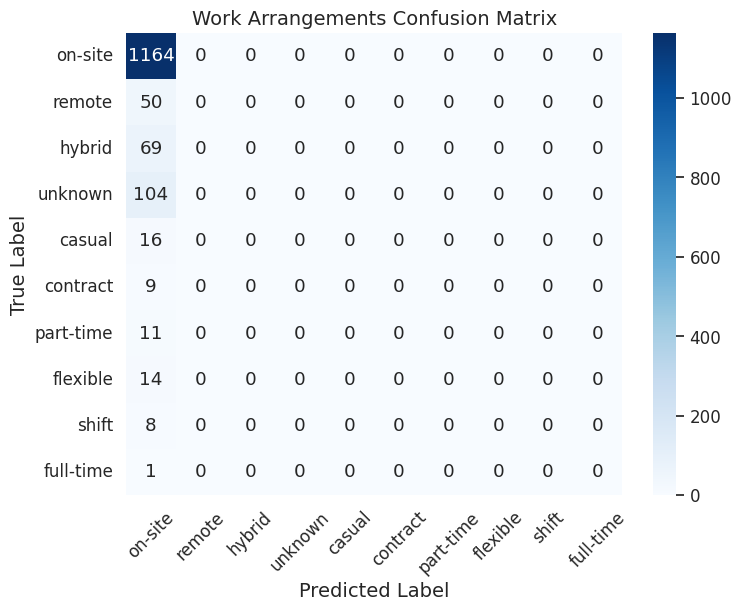

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)
ax = sns.heatmap(cm_work, annot=True, fmt='d', cmap='Blues', xticklabels=work_label_names,
    yticklabels=work_label_names)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.set_title("Work Arrangements Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.show()


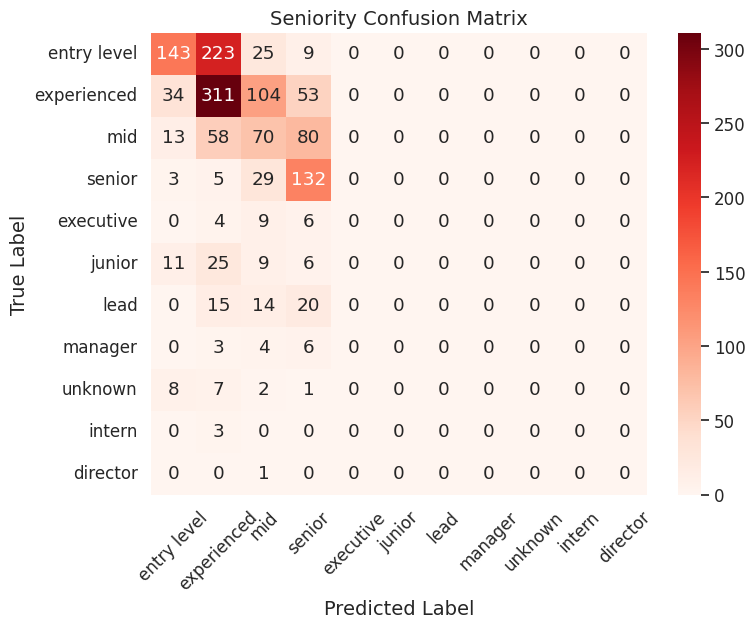

In [55]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)
ax = sns.heatmap(cm_seniority, annot=True, fmt='d', cmap='Reds', xticklabels=seniority_label_names,
    yticklabels=seniority_label_names)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.set_title("Seniority Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [56]:

job_ad = "job title : enterprise digital sales - security abstract : the digital cloud acquisition team urges growth for microsoft by helping customers realize the value of the microsoft cloud. employer : microsoft location : - highlights : long - term incentives : stock award and microsoft employee stock purchase plan, comprehensive medical insurance for employees and dependents, online technical, business, and professional development classes offered contents : overview digital sales enterprise, part of microsoft ' s smc and digital sales organization, empowers our customers through the unique value of the microsoft cloud by building a globally - led, digital - first scale organization aligned with partners. as part of our local subsidiaries or digital sales centers around the world, you will engage a dedicated set of enterprise customers to identify and achieve their business objectives through best - in - class digital assets and partner co - selling. you will also have an opportunity to work collaboratively across teams while living our shared smc and digital sales culture priorities : diversity and inclusivity, wellbeing, sustainability, and marketing obsession. if you have a passion for driving digital - first solutions and delivering customer satisfaction, we invite you to learn more about enterprise digital sales and the value we bring to our customers, partners, and one another, every day. the digital cloud acquisition team drives growth for microsoft by helping customers realize the value of the microsoft cloud. powered by a world - level connected sales and marketing platform, this team leverages marketing insights to reach customers when and where they want to invest digitally to help solve their business problems. wea€™re powered by the latest innovations in microsoft dynamics 365 to engage with stakeholders, collaborate across our global teams, and acquire and retain new business for microsoft. we are looking for an enterprise digital specialist, specializing in security solutions, who will work with our most important customers within our enterprise organization. you will drive the day - to - day execution of microsoft ' s strategic business priorities a€ “ selling best - in - class business services and platforms to our managed customers and building digital transformation momentum for our customers, partners, and microsoft. microsoft continues to invest in cybersecurity and research, to provide our consumers with solutions that secure devices, identities, apps, cloudsa€ ” the fundamental fabric of our company livesa€ ” with the full scale of our comprehensive multi - cloud, multiplatform solutions. your exceptional sales skills, deep understanding of enterprise needs, and ability to build strong customer relationships will be instrumental in achieving sales targets and driving customer success. this role is flexible in that you can work up to 50 % from home. as a security digital specialist, you will play a vital role in driving business growth by generating new leads, engaging with prospective clients, and building strong relationships. you will receive comprehensive training and mentorship to develop your sales skills and gain a deep understanding of microsoft products and solutions. this is an ic role supporting strategic downstream and child accounts selling security. if you are a strong team player, if you have an entrepreneurial spirit, if you are looking to build your sales experience, delivering on outcomes for enterprise customers and if you are interested in joining a creative and inclusive global sales team, this is the role for you. we are looking for strong communicators and collaborators, for motivated individuals who are eager to learn, grow and make an impact and for sellers who are interested in being part of the next wave of connected sales and marketing innovation inside microsoft. microsofta€™s mission is to empower every person and every organization on the planet to achieve more. as employees we come together with a growth mindset, innovate to empower others, and collaborate to realize our shared goals. each day we build on our values of respect, integrity, and accountability to create a culture of inclusion where everyone can thrive at work and beyond. qualifications required / minimum qualifications ( rqs / mqs ) : 6 + years sales and negotiation experience ; or bachelor ' s degree in business management, information technology, marketing ( or equivalent ) or related field and 3 + years sales and negotiation experience or related work or internship experience. additional or preferred qualifications ( pqs ) 6 + years sales and negotiation experience ; or bachelor ' s degree in business management, information technology, marketing ( or equivalent ) or related field and 4 + years sales and negotiation experience or related work or internship experience ; or master ' s degree in business management, information technology, marketing ( or equivalent ) and 1 + year ( s ) sales and negotiation experience or related work., 2 - 5 + years experience selling cloud services to large / global customers., at least 1 year of experience selling to or consulting with, security technology solutions., proven self - starter able to work towards delivery of goals as best practices are being developed., strong presentation, written, and verbal communication skills., understanding of partner ecosystems and the ability to leverage partner solutions / services to solve customer needs., knowledge of enterprise software solutions and cloud platform competitor landscape., demonstrate the business value of microsoft ' s solutions with an understanding of microsoft ' s strategies and products relative to major microsoft competitors., ability to maintain a high level of productivity, manage competing priorities and work effectively with high levels of autonomy and self - direction in a fast - paced, collaborative, and dynamic teaming environment., experience in building and maintaining executive level ( cxo ) stakeholder relationships and leading value proposition conversations aligned to customer priorities and outcomes., capacity to learn and retain knowledge about systems, processes, products, and services quickly and accurately. [UNK], build relationships, collaborate, and influence across organizations, functions, and stakeholder groups., operational and sales excellence discipline, including planning, opportunity qualification and creation, stakeholder communication, services / partner engagement and sales excellence practices including pipeline and opportunity management., a desire to learn, grow, and drive change., fundamental understanding of security threats, solutions, security tools, and network technologiesa€ [UNK].. responsibilities customer first mindset - engage with and enable our customers and key decision - makers, delivering a connected customer engagement experience and driving customer satisfaction, through digital sales excellence, empowered by world - class data, marketing systems and platforms. meet operational standards and maintain reporting accuracy for key metrics a€ “ including response rates, prospecting activity tracking, pipeline, conversion, velocity, and accuracy. adopt program processes, procedures, and tools to provide accurate on - time reporting that maximizes attainment of strategic goals and delivers competitive business insights, trends, and analysis., share best practices, learnings, and customer insights with stakeholder groups to elevate team capabilities and drive change based on insights., work in a fast - paced, collaborative, and dynamic teaming environment with field specialists, technical resources, and partner teams to effectively manage customer opportunities, deliver connected customer experiences, achieve customer outcomes with microsoft ' s leading cloud technologies, and accelerate value across the customer lifecycle., effectively turn prospects and qualified digital leads into opportunities and revenue pipeline and engage with customers across industries, company sizes and types to determine their needs and identify opportunities to fulfill their needs with microsoft ' s leading cloud technologies, with this role particularly focused on the specific solution area you are driving., stay motivated and maintain a positive approach to problem - solving, learning, and development in a rapidly growing business with evolving market conditions and customer needs., develop a strong understanding of your customers, their security challenges, and strategic business objectives to identify their core security needs and connect them with our security solutions., engage with partner ( s ) - leverage and scale through aligning early with global partner solutions ( gps ) organizationa€™s prioritized partners.. benefits / perks listed below may vary depending on the nature of your employment with microsoft and the country where you work. industry leading healthcare, educational resources, discounts on products and services, savings and investments, maternity and paternity leave, generous time away, giving programs, opportunities to network and connect."

In [57]:

def predict_single_job_ad(job_ad, model, tokenizer, max_length=512, device='cpu'):
    # 1. Tokenize the input text
    inputs = tokenizer(
        job_ad,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 2. Model inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        # For multitask: outputs[0] = work_arrangements logits, outputs[1] = seniority logits
        work_logits = outputs[0]
        seniority_logits = outputs[1]

    # 3. Get predicted class indices
    work_pred_idx = torch.argmax(work_logits, dim=1).item()
    seniority_pred_idx = torch.argmax(seniority_logits, dim=1).item()

    # 4. Map indices to label names
    work_pred_label = IDX_TO_WORK_LABELS[work_pred_idx]
    seniority_pred_label = IDX_TO_SENIORITY_LABELS[seniority_pred_idx]

    return work_pred_label, seniority_pred_label


In [58]:

work_label, seniority_label = predict_single_job_ad(job_ad, model, TOKENIZER)

print("Predicted Work Arrangement:", work_label)
print("Predicted Seniority:", seniority_label)



Predicted Work Arrangement: on-site
Predicted Seniority: experienced
